# Topic Classification: Bag-of-words

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
# reduce function was moved to functools in Python 3.0
from functools import reduce

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    
    for i in range(num_examples):
        print("-" * 50, "\nExample #", i + 1, "- Label:", newsgroups_train.target_names[train_labels[i]])
        print("-" * 50)
        print(train_data[i], '\n')
        
        #\n", "-" * 50
        
### STUDENT END ###
P1()

-------------------------------------------------- 
Example # 1 - Label: comp.graphics
--------------------------------------------------
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

-------------------------------------------------- 
Example # 2 - Label: talk.religion.misc
--------------------------------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():

    ### a) CountVectorizer
    print("\n", "-" * 60, "\n a) CountVectorizer\n", "-" * 60)
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    print("Vocabulary size:", X.shape[1])
    print("Avg. number of non-zero features per example: {:.2f}".format(X.getnnz(axis=1).mean()))
    print("Fraction of entries that are non-zero: {:.4%}".format(X.nnz / reduce(lambda x,y: x*y, X.shape)))
  
    ### b) Vocabulary
    print("\n", "-" * 60, "\n b) CountVectorizer - 0th and last feature strings\n", "-" * 60)
    
    print("First word:", vectorizer.get_feature_names()[0])
    print("Last word:", vectorizer.get_feature_names()[-1])
    
    ### c) 4 word vocabulary
    print("\n", "-" * 60, "\n c) Specify your own 4 word vocabulary\n", "-" * 60)

    vocab4 = CountVectorizer()
    vocab4.vocabulary = ["atheism", "graphics", "space", "religion"]
    vocab4_train = vocab4.transform(train_data)
    print("vocab4_train shape:", vocab4_train.shape)
    print("Average number of non-zero features per example: {:.3f}".format(vocab4_train.getnnz(axis=1).mean()))

    ### d) Bigrams and trigrams
    print("\n", "-" * 60, "\n d) Bigram and Trigram extraction\n", "-" * 60)
    
    # (2,2) means only bigrams
    bigrams = CountVectorizer(analyzer='char', ngram_range=(2,2))
    bigrams_fit = bigrams.fit_transform(train_data)
    print("Bigram vocabulary size:  {:>5}".format(len(bigrams.vocabulary_)))

    # (3,3) means only trigrams
    trigrams = CountVectorizer(analyzer='char', ngram_range=(3,3))
    trigrams_fit = trigrams.fit_transform(train_data)
    print("Trigram vocabulary size: {:>5}".format(len(trigrams.vocabulary_)))

    ### e) Pruning words appearing < 10 documents
    print("\n", "-" * 60, "\n e) Pruned vocabulary that appear in < 10 documents\n", "-" * 60)
    # min_df = 10 means "ignore terms that appear in less than 10 documents"
    vector_10 = CountVectorizer(min_df = 10)
    vector_10.fit_transform(train_data)
    print('Pruned vocabulary size:', len(vector_10.vocabulary_))

    ### f) What fraction of words in the dev data are missing from the vocabulary
    print("\n", "-" * 60, "\n f) Words in dev that were not trained: \n", "-" * 60)
    
    vectorizer = CountVectorizer()
    vector_dev = vectorizer.fit_transform(dev_data)
    # .keys() contains the words
    vocab_dev = set(vectorizer.vocabulary_.keys())

    vectorizer = CountVectorizer()
    vector_train = vectorizer.fit_transform(train_data)
    vocab_train = set(vectorizer.vocabulary_.keys())

    # Find the missing words via diff
    diff_words = len(vocab_dev.difference(vocab_train))
    print('Words in dev not in train: {} ({:.2%})'.format(diff_words, diff_words / len(vocab_dev)))
    
### STUDENT END ###
P2()


 ------------------------------------------------------------ 
 a) CountVectorizer
 ------------------------------------------------------------
Vocabulary size: 26879
Avg. number of non-zero features per example: 96.71
Fraction of entries that are non-zero: 0.3598%

 ------------------------------------------------------------ 
 b) CountVectorizer - 0th and last feature strings
 ------------------------------------------------------------
First word: 00
Last word: zyxel

 ------------------------------------------------------------ 
 c) Specify your own 4 word vocabulary
 ------------------------------------------------------------
vocab4_train shape: (2034, 4)
Average number of non-zero features per example: 0.268

 ------------------------------------------------------------ 
 d) Bigram and Trigram extraction
 ------------------------------------------------------------
Bigram vocabulary size:   3291
Trigram vocabulary size: 32187

 -------------------------------------------------

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
def P3():
### STUDENT START ###
    #Use GridSearchCV to find the best parameters for the models
    
    # Vectorize first
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    ### a) KNN model
    neighbors = {'n_neighbors': [1, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300]}
    knn = KNeighborsClassifier() # initialize
    # cv parameter added to remove warning
    grid_knn = GridSearchCV(knn, neighbors, cv=5)
    grid_knn.fit(X_train, train_labels)

    # Optimal KNN == 150
    print("\n", "-" * 60, "\n a) K Nearest Neighbors model\n", "-" * 60)
    print("  Optimal KNN classifier: {}".format(list(grid_knn.best_params_.values())))
    
    clf_knn = KNeighborsClassifier(n_neighbors=150)
    clf_knn.fit(X_train, train_labels)
    knn_pred = clf_knn.predict(X_dev)
    knn_f1 = metrics.f1_score(dev_labels, knn_pred, average='weighted')
    print("  f1-score: {:.1%}".format(knn_f1))
    
    ### b) Multinomial Naive Bayes model
    alphas = {'alpha': [0.0001, 0.001, .005, .01, .02, 0.5, 0.075, 1, 2, 5, 10]}
    clf_mnb = MultinomialNB(fit_prior=False)
    grid_mnb = GridSearchCV(clf_mnb, alphas, cv=5)
    grid_mnb.fit(X_train, train_labels)

    # Optimal alpha = 0.01
    print("\n", "-" * 60, "\n b) Multinomial Naive Bayes model\n", "-" * 60)
    print("  Optimal alpha: {}".format(list(grid_mnb.best_params_.values())))

    mnb = MultinomialNB(fit_prior=False, alpha=.01)
    mnb.fit(X_train, train_labels)
    mnb_pred = mnb.predict(X_dev)
    mnb_f1 = metrics.f1_score(dev_labels, mnb_pred, average='weighted')
    print("  f1-score: {:.1%}".format(mnb_f1))
    
    ### c) Logistic RegressXion + L2
    weights = { 'C': [.01, .1, .2, .3, .4, .5, .8, 1, 1.2, 1.5, 2, 5, 10] }  
    logreg = LogisticRegression(penalty='l2', solver='liblinear', multi_class='auto')
    grid_LR = GridSearchCV(logreg, weights, cv=5)
    grid_LR.fit(X_train, train_labels)

    # Optimal C parameter = 0.5
    print("\n", "-" * 60, "\n c) Logistic Regression with L2 Regularization model\n", "-" * 60)
    print("  Optimal C Parameter: {}".format(list(grid_LR.best_params_.values())))
    
    logreg = LogisticRegression(penalty='l2', C=0.5, solver='liblinear', multi_class='auto')
    logreg.fit(X_train, train_labels)
    logreg_preds = logreg.predict(X_dev)
    logreg_f1 = metrics.f1_score(dev_labels, logreg_preds, average='weighted')
    print("  f1-score: {:.1%}".format(logreg_f1))

    ### c) Sum of squared coefficients
    print("\n", "-" * 60, "\n Sum of squared coefficients for the different classes\n", "-" * 60)

    #using category names defined in prior section
    print("   C weight  {:>8}   {:>8}   {:>6}  {:>7}".format(*categories))
    for c in [.01, .1, .2, .3, .4, .5, .8, 1, 1.2, 1.5, 2, 5, 10]:    
        logreg = LogisticRegression(penalty='l2', C=c, solver='liblinear', multi_class='auto')
        logreg.fit(X_train, train_labels)
        ss_coefs = [(logreg.coef_[i]**2).sum() for i in range(4)]
        print("      {:<4}   {:>9.1f}         {:>8.1f}          {:>8.1f}      {:>7.1f}".format(c, *ss_coefs))
    
### STUDENT END ###
P3()


 ------------------------------------------------------------ 
 a) K Nearest Neighbors model
 ------------------------------------------------------------
  Optimal KNN classifier: [150]
  f1-score: 42.2%

 ------------------------------------------------------------ 
 b) Multinomial Naive Bayes model
 ------------------------------------------------------------
  Optimal alpha: [0.01]
  f1-score: 77.1%

 ------------------------------------------------------------ 
 c) Logistic Regression with L2 Regularization model
 ------------------------------------------------------------
  Optimal C Parameter: [0.5]
  f1-score: 70.8%

 ------------------------------------------------------------ 
 Sum of squared coefficients for the different classes
 ------------------------------------------------------------
   C weight  alt.atheism   talk.religion.misc   comp.graphics  sci.space
      0.01         2.5              2.9               2.9          2.3
      0.1         27.1             24.7  

**ANSWER:**

a. K-Nearest Neighbor classifier does not perform well with the high number of features (10k+). The high number of features makes it difficult to classify a nearest neighbor accurately. It would potentially improve if more importance was placed on a smaller set of words.

b. Logistic Regression trains weights for each class to reduce the error, while Naive Bayes fits weights independently to reduce the error which in this case can help to better identify specific words that have topic importance. Also, since the number of features was greater than the data set this could result in overfitting for Logistic Regression.

c. The C parameter is the inverse of regularization strength. So the higher the C, the lower the regularization; therefore, the larger the weights the penalty is not as severe. So as C increases, the sum of the squared weights increases.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
def PrintOut(coefficients, vocabulary):
    ''' Retrieve the 5 features with the largest weights and print the results'''
    # Get the features
    features = []
    for i in range(coefficients.shape[0]):
        features.extend(np.argsort(-coefficients[i])[:5]) 
    
    # print out the table
    print("Features       {:>8}   {:>8}   {:>6}   {:>7}".format(*categories)) # As provided
    for item in features:
        coefs = map(lambda x: x[item], coefficients)
        # color coding and formatting for positive numbers
        green = lambda x: "\x1b[32m{:>7.3f} \x1b[0m".format(x) if x > 0 else "{:>7.3f} ".format(x)
        coefs_green = map(green, coefs)
        print("{:<13}   {:>8}          {:>8}          {:>8}      {:>8}"
              .format(vocabulary[item], *coefs_green))
    return()

def P4():
### STUDENT START ###
    ##### a) Unigram
    print("\n", "-" * 80, "\n a) Unigram Logistic Regression\n", "-" * 80)
    vectorizer_uni = CountVectorizer()
    X_train_uni = vectorizer_uni.fit_transform(train_data)
    logreg_uni = LogisticRegression(penalty='l2', C=0.5, solver='liblinear', multi_class='auto')
    logreg_uni.fit(X_train_uni, train_labels)
    PrintOut(logreg_uni.coef_, vectorizer_uni.get_feature_names())
    
    ##### b) Bigram
    print("\n", "-" * 80, "\n b) Bigram Logistic Regression\n", "-" * 80)
    vectorizer_bi = CountVectorizer(ngram_range=(2,2))
    X_train_bi = vectorizer_bi.fit_transform(train_data)
    logreg_bi = LogisticRegression(penalty='l2', C=0.5, solver='liblinear', multi_class='auto')
    logreg_bi.fit(X_train_bi, train_labels)
    PrintOut(logreg_bi.coef_, vectorizer_bi.get_feature_names())

### STUDENT END ###
P4()


 -------------------------------------------------------------------------------- 
 a) Unigram Logistic Regression
 --------------------------------------------------------------------------------
Features       alt.atheism   talk.religion.misc   comp.graphics   sci.space
atheists          0.834            -0.093            -0.267        -0.638 
bobby             0.823            -0.191            -0.286        -0.387 
religion          0.798            -0.509            -0.659        -0.051 
atheism           0.795            -0.348            -0.367        -0.377 
deletion          0.724            -0.250            -0.272        -0.270 
graphics         -0.641             1.626            -1.103        -0.626 
image            -0.470             1.117            -0.672        -0.381 
file             -0.275             1.059            -0.683        -0.506 
3d               -0.303             0.941            -0.571        -0.318 
computer          0.071             0.844          

**ANSWER:**  Only a few of the features in the unigram list are found in the bigram list.  The unigram list has a very defined diagonal for the positive terms.  The bigram had some features that were had positive coefficients for other classes, "cheers kent".  Also, the bigram feature list had very vague terms that seemed inconsequential to the label, more so than the unigram list.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
# https://gist.github.com/sebleier/554280 - shamiradjaku commented on Apr 17
MYSQL_stop_words = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would", "able", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "afterwards", "ah", "almost", "alone", "along", "already", "also", "although", "always", "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "arent", "arise", "around", "aside", "ask", "asking", "auth", "available", "away", "awfully", "b", "back", "became", "become", "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "believe", "beside", "besides", "beyond", "biol", "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "couldnt", "date", "different", "done", "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "former", "formerly", "forth", "found", "four", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit", "however", "hundred", "id", "ie", "im", "immediate", "immediately", "importance", "important", "inc", "indeed", "index", "information", "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may", "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug", "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none", "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere", "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old", "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside", "overall", "owing", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "said", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "shed", "shes", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "sufficiently", "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th", "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre", "think", "thou", "though", "thoughh", "thousand", "throug", "throughout", "thru", "thus", "til", "tip", "together", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un", "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols", "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went", "werent", "whatever", "what'll", "whats", "whence", "whenever", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "whim", "whither", "whod", "whoever", "whole", "who'll", "whomever", "whos", "whose", "widely", "willing", "wish", "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes", "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows", "apart", "appear", "appreciate", "appropriate", "associated", "best", "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning", "consequently", "consider", "considering", "corresponding", "course", "currently", "definitely", "described", "despite", "entirely", "exactly", "example", "going", "greetings", "hello", "help", "hopefully", "ignored", "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar", "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second", "secondly", "sensible", "serious", "seriously", "sure", "t's", "third", "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another", "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "co", "op", "research-articl", "pagecount", "cit", "ibid", "les", "le", "au", "que", "est", "pas", "vol", "el", "los", "pp", "u201d", "well-b", "http", "volumtype", "par", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a1", "a2", "a3", "a4", "ab", "ac", "ad", "ae", "af", "ag", "aj", "al", "an", "ao", "ap", "ar", "av", "aw", "ax", "ay", "az", "b1", "b2", "b3", "ba", "bc", "bd", "be", "bi", "bj", "bk", "bl", "bn", "bp", "br", "bs", "bt", "bu", "bx", "c1", "c2", "c3", "cc", "cd", "ce", "cf", "cg", "ch", "ci", "cj", "cl", "cm", "cn", "cp", "cq", "cr", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d2", "da", "dc", "dd", "de", "df", "di", "dj", "dk", "dl", "do", "dp", "dr", "ds", "dt", "du", "dx", "dy", "e2", "e3", "ea", "ec", "ed", "ee", "ef", "ei", "ej", "el", "em", "en", "eo", "ep", "eq", "er", "es", "et", "eu", "ev", "ex", "ey", "f2", "fa", "fc", "ff", "fi", "fj", "fl", "fn", "fo", "fr", "fs", "ft", "fu", "fy", "ga", "ge", "gi", "gj", "gl", "go", "gr", "gs", "gy", "h2", "h3", "hh", "hi", "hj", "ho", "hr", "hs", "hu", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ic", "ie", "ig", "ih", "ii", "ij", "il", "in", "io", "ip", "iq", "ir", "iv", "ix", "iy", "iz", "jj", "jr", "js", "jt", "ju", "ke", "kg", "kj", "km", "ko", "l2", "la", "lb", "lc", "lf", "lj", "ln", "lo", "lr", "ls", "lt", "m2", "ml", "mn", "mo", "ms", "mt", "mu", "n2", "nc", "nd", "ne", "ng", "ni", "nj", "nl", "nn", "nr", "ns", "nt", "ny", "oa", "ob", "oc", "od", "of", "og", "oi", "oj", "ol", "om", "on", "oo", "oq", "or", "os", "ot", "ou", "ow", "ox", "oz", "p1", "p2", "p3", "pc", "pd", "pe", "pf", "ph", "pi", "pj", "pk", "pl", "pm", "pn", "po", "pq", "pr", "ps", "pt", "pu", "py", "qj", "qu", "r2", "ra", "rc", "rd", "rf", "rh", "ri", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "rv", "ry", "s2", "sa", "sc", "sd", "se", "sf", "si", "sj", "sl", "sm", "sn", "sp", "sq", "sr", "ss", "st", "sy", "sz", "t1", "t2", "t3", "tb", "tc", "td", "te", "tf", "th", "ti", "tj", "tl", "tm", "tn", "tp", "tq", "tr", "ts", "tt", "tv", "tx", "ue", "ui", "uj", "uk", "um", "un", "uo", "ur", "ut", "va", "wa", "vd", "wi", "vj", "vo", "wo", "vq", "vt", "vu", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y2", "yj", "yl", "yr", "ys", "yt", "zi", "zz"]
MY_suffix = ['able', 'acy', 'al', 'ance', 'ate', 'dom', 'en', 'ence', 'er', 'esque', 'ful', 'fy', 'ible', 'ic', 'ical', 'ify', 'ing', 'ious', 'ise', 'ish', 'ism', 'ist', 'ity', 'ive', 'ize', 'less', 'ly', 'ment', 'ness', 'or', 'ous', 'ship', 'sion', 'tion', 'ty']

In [8]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    
    # lower case
    s = s.lower()
    # remove punctuation
    s = re.sub('\'', '', s)
    # replace sequence of numbers
    s = re.sub(r'\d+', ' ', s)   
    # Group digits and remove non-alphanumeric chars
    s = re.sub('\d+','#', s)
    s = re.sub('[_@\'\?!".,:-<>]', ' ', s)
    
    # Split for stop words and suffixes
    split_words_new = []
    split_words = s.split()
    
    # remove stop words
    for i in split_words:
        if i not in MYSQL_stop_words:
            # trim suffixes
            for item in MY_suffix:
                if i[-len(i):] == item:
                    i = i[:-len(i)]
                    break     #after one is found, break
            split_words_new.append(i)

    s = ' '.join(split_words_new)
    return s

### STUDENT END ###

def P5():
### STUDENT START ###

    # Empty preprocessing
    empty_vector = CountVectorizer(preprocessor=empty_preprocessor)
    empty_train = empty_vector.fit_transform(train_data)
    empty_dev = empty_vector.transform(dev_data)
    empty_size = len(empty_vector.get_feature_names())

    # add solver and multi-class parameters to avoid warnings
    empty_logReg = LogisticRegression(penalty='l2', C=0.5, solver='liblinear', multi_class='auto')
    empty_logReg.fit(empty_train, train_labels)            
    empty_predict = empty_logReg.predict(empty_dev)
    empty_f1 = metrics.f1_score(dev_labels, empty_predict, average='weighted')
    
    # Better preprocessor
    better_vector = CountVectorizer(preprocessor=better_preprocessor)
    better_train = better_vector.fit_transform(train_data)
    better_dev = better_vector.transform(dev_data)
    better_size = len(better_vector.get_feature_names())

    better_logReg = LogisticRegression(penalty='l2', C=0.5, solver='liblinear', multi_class='auto')
    better_logReg.fit(better_train, train_labels)            
    better_predict = better_logReg.predict(better_dev)
    better_f1 = metrics.f1_score(dev_labels, better_predict, average='weighted')

    # Output
    print("\nNo Text Preprocessing vs. Text Preprocessing:")
    print(" -> Vocabulary size changed from {:,} to {:,} (-{:.1%})"
          .format(empty_size, better_size, (empty_size - better_size) / empty_size))
    print(" -> f1-score changed from {:.1%} to {:.1%} (+{:.1%})"
          .format(empty_f1, better_f1, better_f1 - empty_f1))

### STUDENT END ###

P5()


No Text Preprocessing vs. Text Preprocessing:
 -> Vocabulary size changed from 33,291 to 24,008 (-27.9%)
 -> f1-score changed from 70.7% to 73.0% (+2.3%)


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]


 -------------------------------------------------------------------------------- 
 a) Comparing the non-zero coefficients
 --------------------------------------------------------------------------------
  L1: 1,226
  L2: 107,516

 -------------------------------------------------------------------------------- 
 b) Vocabulary Size vs. Accuracy
 --------------------------------------------------------------------------------
  1)Training using C = 0.001  Vocab =      2  Accuracy = 34.2%
  2)Training using C = 0.005  Vocab =     11  Accuracy = 47.5%
  3)Training using C =  0.01  Vocab =     18  Accuracy = 48.5%
  4)Training using C =  0.03  Vocab =     65  Accuracy = 59.0%
  5)Training using C =  0.05  Vocab =    122  Accuracy = 63.2%
  6)Training using C =  0.07  Vocab =    157  Accuracy = 62.7%
  7)Training using C =   0.1  Vocab =    208  Accuracy = 68.0%
  8)Training using C =   0.2  Vocab =    358  Accuracy = 69.2%
  9)Training using C =   0.3  Vocab =    516  Accuracy = 67.8%
 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 11)Training using C =     1  Vocab =  1,150  Accuracy = 67.9%
 12)Training using C =     5  Vocab =  2,260  Accuracy = 69.4%
 13)Training using C =    10  Vocab =  2,736  Accuracy = 68.3%
 14)Training using C =    20  Vocab =  3,649  Accuracy = 68.8%


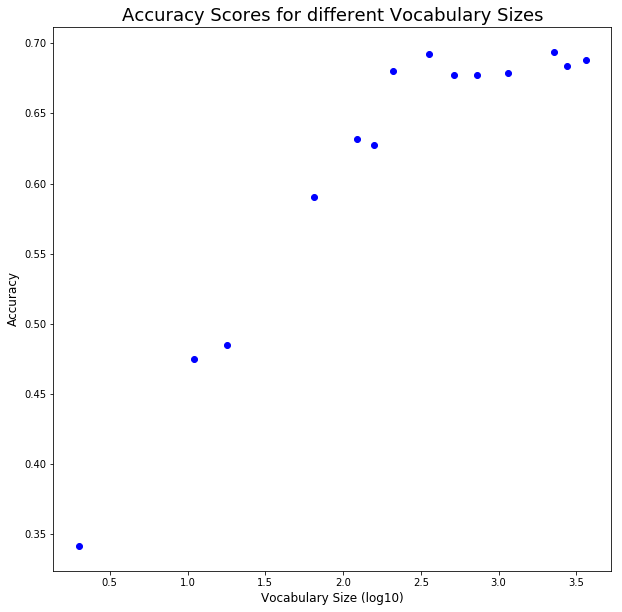

In [9]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    ##### a) Comparing non-zero coefficients
    print("\n", "-" * 80, "\n a) Comparing the non-zero coefficients\n", "-" * 80)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
  
    logReg_l1 = LogisticRegression(penalty='l1', C=0.5, tol=0.01, solver='liblinear', multi_class='auto', max_iter=1000)
    logReg_l1.fit(X, train_labels)
    print("  L1: {:,}".format(len(logReg_l1.coef_.nonzero()[0])))

    logReg_l2 = LogisticRegression(penalty='l2', C=0.5, tol=0.01, solver='liblinear', multi_class='auto', max_iter=1000)
    logReg_l2.fit(X, train_labels)
    print("  L2: {:,}".format(len(logReg_l2.coef_.nonzero()[0])))
 
    #### b) plot vacabulary size vs. accuracy
    cValues = [.001, .005, .01, .03, .05, .07, .1, .2, .3, .5, 1, 5, 10, 20]
    vocabSizes = []   # total size of each Cvalue vocab list -> used in plot
    accuracies = []   # accuracy list for each Cvalue -> used in plot
    x = 0
    
    count_dev = vectorizer.transform(dev_data)
    print("\n", "-" * 80, "\n b) Vocabulary Size vs. Accuracy\n", "-" * 80)
    for c in cValues:
        vocab = []    # new vocabulary list
        x += 1
        # increased max_iter to reach convergence, added solver & multi_class to remove most warning
        LogReg_l1 = LogisticRegression(penalty='l1', C=c, tol = 0.01, solver='liblinear', multi_class='auto', max_iter=5000)
        LogReg_l1.fit(X, train_labels)
        
        # Begin to reduce the vocab size by removing features that have a zero weight, then use this vocab list
        # and retrain using L2.
        
        # Find non-zero cases and store word in a new vocab list
        indices = np.sum(LogReg_l1.coef_ != 0, axis = 0) > 0
        # key = word, value = index
        for key, value in vectorizer.vocabulary_.items():
            # pass index in to return word to be appended to list 
            if indices[value]:
                vocab.append(key)
                
        # With new vocab list use L2 linear regression to find the accuracy
        vectNew = CountVectorizer(vocabulary=vocab)
        count_trainNew = vectNew.transform(train_data)
        count_devNew = vectNew.transform(dev_data)
        vocabSizes.append(count_trainNew.shape[1])
        
        logReg_l2 = LogisticRegression(penalty='l2', C=c, tol = 0.01, solver='liblinear', multi_class='auto', max_iter=5000)
        logReg_l2.fit(count_trainNew, train_labels)
        accuracy = logReg_l2.score(count_devNew, dev_labels)
        accuracies.append(accuracy)
        print("{:3})Training using C = {:>5}  Vocab ={:7,}  Accuracy = {:.1%}".format(x,c,len(vocab), accuracy))
        
    # Plot output: vocab size vs accuracy
    plt.figure(figsize=(10, 10))
    # change vocab size to Log10 for a better display
    plt.plot(np.log10(vocabSizes), accuracies, 'o', color='blue')
    plt.title('Accuracy Scores for different Vocabulary Sizes', size=18)
    plt.xlabel('Vocabulary Size (log10)', size=12)
    plt.ylabel('Accuracy', size=12)
    plt.show()
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [10]:
def P7():
    
    ### STUDENT START ###
 
    # TF-IDF Vectorize
    vect = TfidfVectorizer()
    tfidf_train = vect.fit_transform(train_data)
    tfidf_dev = vect.transform(dev_data) 
    
    # Train model and get predicted probabilities
    # added solver and multi-class parameters to avoid warnings
    logreg_l2 = LogisticRegression(penalty='l2', C=100, solver='liblinear', multi_class='auto')
    logreg_l2.fit(tfidf_train, train_labels)
    predicted = logreg_l2.predict(tfidf_dev)
    pred_prob = logreg_l2.predict_proba(tfidf_dev)
    
    # Find largest R: Calculate max predicted prob. / predicted prob. of the correct label
    R = [max(x) / x[dev_labels[i]] for i, x in enumerate(pred_prob)]
    # Sort and save the 3 highest R values
    results = np.argsort(-np.array(R))[:3]
    
    # categories contains the labels and is defined above
    for i in results:
        print("\n" + "=" * 80)
        print("Document #: {}".format(i))
        print(" - Predicted topic -> {}".format(categories[predicted[i]]))
        print(" - Correct topic   -> {}".format(categories[dev_labels[i]]))
        print(" - R: {:.2f}".format(R[i]))
        print("\n{}".format(dev_data[i]))
        
    ### STUDENT END ###
P7()


Document #: 215
 - Predicted topic -> talk.religion.misc
 - Correct topic   -> sci.space
 - R: 929.36

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
f

**ANSWER:**
CountVectorizer just counts the word frequencies while TFIDFVectorizer increases the value proportionally to the count, but is offset by the frequency of the word in the collection. - This is the IDF (inverse document frequency part).

Challenges:  
1) documents that do not have much text is harder to predict  
2) the labels on shorter documents might be incorrect  
3) the documents may contain more related words from other topics which makes it more challenging to identify.  

Solutions:  
1) provide additional context in addition to the document  
2) use trigrams or more words around the feature to determine context.  
3) atheism and religion can share a significant amount of words, I'd be more refined/constrictive on 'atheism' so the odds of success will be higher (reduce false positives). 
